# Context

Company X is promoting a campaign where users who makes payment by scanning QR code at merchants' store will be rewarded with Rebate.

Rebate is determined at 30% of transaction value, capped at $2 per txn.

It is reported that some users are colluding with merchants to abuse this promotion campaign. Our job is to identify the potential abusers, both users and merchants.

# Library import

In [43]:
# Data manipulation
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta

# Options for pandas
from IPython.core.display import display, HTML
pd.options.display.max_columns = None
display(HTML("<style>.container { width:85% !important; }</style>"))
pd.options.display.float_format = '{:,}'.format

# Visualizations
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

# ML
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

# graph
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import girvan_newman


import warnings
warnings.filterwarnings("ignore")

# utils
from utils import utils
from utils.utils import time_variance
from utils.utils import short_timedelta_highlight


# Solution

In [3]:
Orders = pd.read_csv('Rebate Fraud detection.csv') #the data was anonymised

### Cleansing & EDA

In [4]:
Orders.head()

,txn_time,txn_date,order_id,uid,shop_id,gmv,rebate
0,10/30/2015 13:37,10/30/2015,8867,161617,11709,7.0,2.0
1,10/30/2015 20:26,10/30/2015,119519,867365,120249,8.0,2.0
2,10/30/2015 12:22,10/30/2015,986559,401483,120549,12.5,2.0
3,10/30/2015 9:46,10/30/2015,942099,213258,120705,8.2,2.0
4,10/30/2015 21:56,10/30/2015,139417,3391,121353,26.0,2.0


In [5]:
Orders.describe(include='all')

,txn_time,txn_date,order_id,uid,shop_id,gmv,rebate
count,4611,4611,"4,611.0","4,611.0","4,611.0","4,611.0","4,611.0"
unique,2521,4,NaN,NaN,NaN,NaN,NaN
top,11/2/2015 13:05,11/2/2015,NaN,NaN,NaN,NaN,NaN
freq,8,1529,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,"530,295.0561700282","420,764.422684884","131,795.8366948601",13.898523096942098,1.6813597918022125
std,NaN,NaN,"274,164.47839037824","319,435.26185221475","108,082.19736593976",19.39903931831104,0.6520429723315134
min,NaN,NaN,286.0,171.0,"1,281.0",0.0,0.0
25%,NaN,NaN,"309,398.5","100,364.0","67,365.0",7.0,1.95
50%,NaN,NaN,"570,966.0","395,464.0","100,845.0",8.49,2.0
75%,NaN,NaN,"768,706.0","698,105.5","130,125.0",13.9,2.0


In [6]:
Orders = Orders[Orders['gmv']>0]

In [7]:
Orders.txn_time = pd.to_datetime(Orders.txn_time)

In [8]:
px.histogram(Orders, x='gmv')

# Fraud detection - Heuristic approach

Fraud indicators:
1. An user makes an unreasonably high number of transactions
2. A pair of shop owner - user makes an unreasonably high number of transactions
3. The rebate is at maximum, i.e. $2
4. Transactions are frequent within a short period of time
5. Rebate sum by user is maximised

### Indicator 1: An user makes an unreasonably high number of transactions

In [9]:
# Order count by uid
df = pd.DataFrame(Orders.groupby('uid').agg(['sum', 'count']))['rebate']
df.columns = ['Rebate_sum_by_user','Order_count_by_user']
px.histogram(df, x='Order_count_by_user')

In [10]:
Orders_extra = pd.merge(Orders, df, left_on='uid', right_index=True, how = 'left')

In [11]:
indicator_1 = Orders_extra['Order_count_by_user']>=10

### Indicator 2: A pair of shop owner - user makes an unreasonably high number of transactions

In [12]:
# Order count by shop-user pair
df = pd.DataFrame(Orders.groupby(['uid', 'shop_id']).agg(['sum', 'count']))['rebate']
df.columns = ['Rebate_sum_by_shop&user','Order_count_by_shop&user']
px.histogram(df, x='Order_count_by_shop&user')

In [13]:
Orders_extra = pd.merge(Orders_extra, df, left_on=['uid', 'shop_id'], right_index=True)

In [14]:
indicator_2 = Orders_extra['Order_count_by_shop&user']>=3

### Indicator_3: The rebate is at maximum, i.e. near $2

In [15]:
px.histogram(Orders_extra, x='rebate')

Since most rebate are $2, i.e. most users take full advantage of the rebate, this indicator is not effective. We shall drop this indicator.

## Indicator_4: Transactions are frequent within a short period of time

In [16]:
Orders_extra.sort_values(by=['txn_time'], ascending=False, inplace=True)

df = Orders_extra.groupby(by='uid')[['txn_time', 'gmv', 'rebate', 'order_id']]              \
  .agg({'txn_time': time_variance, 'gmv': 'mean', 'rebate': 'mean', 'order_id': 'count'})   \
  .dropna()                                                                                 \
  .reset_index()                                                                            \
  .sort_values('txn_time')
df.columns = ['uid', 'time_variance', 'average gmv', 'average rebate', 'count of order']
df.head(10).style.apply(short_timedelta_highlight, subset=['time_variance'])

,uid,time_variance,average gmv,average rebate,count of order
0,1018,0 days 00:00:00,4.750000,1.000000,4
127,308120,0 days 00:00:00,4.500000,1.000000,4
125,297464,0 days 00:00:00,4.500000,1.000000,4
122,285462,0 days 00:00:00,4.500000,1.000000,4
120,282727,0 days 00:00:00,5.500000,1.142857,7
258,839064,0 days 00:00:00,4.500000,1.000000,4
115,265578,0 days 00:00:00,10.000000,2.000000,3
113,263635,0 days 00:00:00,8.010000,2.000000,4
112,259847,0 days 00:00:00,6.700000,1.333333,6
261,849561,0 days 00:00:00,4.833333,1.000000,6


In [17]:
fig = go.Figure()
trace = go.Histogram(x=df['time_variance'].astype('timedelta64[m]'),
                     xbins=dict(
                     start=0,
                     size=20),
                     autobinx=False
                     )
fig.add_trace(trace)

In [18]:
indicator_4_uid = df.loc[df.time_variance <= timedelta(minutes=20), 'uid']
indicator_4 = Orders_extra['uid'].isin(indicator_4_uid)

## Indicator 5: Rebate sum by user is maximised


In [19]:
px.histogram(Orders_extra,
             x = 'Rebate_sum_by_user')

In [28]:
indicator_5 = Orders_extra['Rebate_sum_by_user']==Orders_extra['Rebate_sum_by_user'].max()

## Combine all indicators

In [21]:
for indicator in ['indicator_1', 'indicator_2', 'indicator_4', 'indicator_5']:
  Orders_extra[indicator] = eval(indicator)
Orders_extra['Number of flags'] = Orders_extra.indicator_1*1 + Orders_extra.indicator_2*1 \
                                 + Orders_extra.indicator_4*1 + Orders_extra.indicator_5*1

In [22]:
# Suspected orders are those with 3 flags or higher
Suspected_orders = Orders_extra[Orders_extra['Number of flags']>=3]

In [29]:
Suspected_uid = sorted(Suspected_orders['uid'].unique().tolist())
Suspected_shop_id = sorted(Suspected_orders['shop_id'].unique().tolist())
print(f' {len(Suspected_uid)} Suspected uid: {Suspected_uid}')
print(f' {len(Suspected_shop_id)} Suspected shop id: {Suspected_shop_id}')

 7 Suspected uid: [23942, 366427, 653121, 653495, 668004, 682428, 868549]
 13 Suspected shop id: [51753, 57357, 69081, 69345, 71121, 81729, 82557, 82653, 85821, 90153, 91161, 91485, 93369]


# Unsupervised approach

Another method is that we can treat shops and uids as bipartite graph, cluster it. Since we already have some suspected uid from the heuristic approach, we can find uid/shopid of the same cluster.

For our graph, each vertex will be a uid/shop_id. Each edge weight will be the average rebate value.

In [30]:
Orders

,txn_time,txn_date,order_id,uid,shop_id,gmv,rebate
0,2015-10-30 13:37:00,10/30/2015,8867,161617,11709,7.0,2.0
1,2015-10-30 20:26:00,10/30/2015,119519,867365,120249,8.0,2.0
2,2015-10-30 12:22:00,10/30/2015,986559,401483,120549,12.5,2.0
3,2015-10-30 09:46:00,10/30/2015,942099,213258,120705,8.2,2.0
4,2015-10-30 21:56:00,10/30/2015,139417,3391,121353,26.0,2.0
...,...,...,...,...,...,...,...
4606,2015-11-02 18:22:00,11/2/2015,816862,22502,119037,45.0,2.0
4607,2015-11-02 14:09:00,11/2/2015,755701,344758,119133,8.0,2.0
4608,2015-11-02 09:54:00,11/2/2015,695645,907345,119253,25.0,2.0
4609,2015-11-02 20:48:00,11/2/2015,847428,103102,119253,103.0,2.0


In [60]:
graph_df = Orders.groupby(['uid', 'shop_id'])['rebate'].agg({'mean', 'count'}).reset_index()

In [61]:
G = nx.from_pandas_edgelist(graph_df, 'uid', 'shop_id', ["count", "mean"])

In [62]:
suspected_nodes = Suspected_shop_id + Suspected_uid
H = nx.subgraph(G, suspected_nodes)

In [63]:
def color_map(graph):
    global Orders
    color_map = []
    for node in graph:
        if node in Orders['uid'].to_list():
            color_map.append('blue')
        else: 
            color_map.append('green')
    return color_map

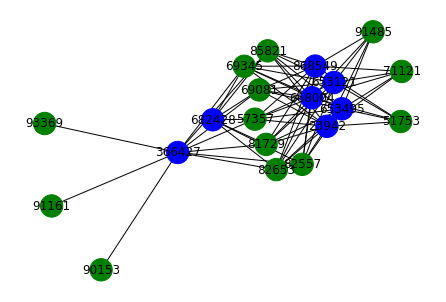

In [64]:
nx.draw(H,with_labels = True,node_color=color_map(H),node_size=500)

Turns out, all suspected uid and shops are all linked together in one cluster. This confirms our suspicion. We will perform a scanning to get any other node that are connected to this cluster.

In [67]:
communities = greedy_modularity_communities(G)

In [75]:
# check if the suspected ids belong to how many cluster, and each of these cluster contains how many suspected id?
for c in communities:
    suspected_count = len(set.intersection(set(suspected_nodes), set(c)))
    if suspected_count:
        print(suspected_count)
        suspected_cluster = c

20


All these ids belong to a single cluster! Lets draw that cluster

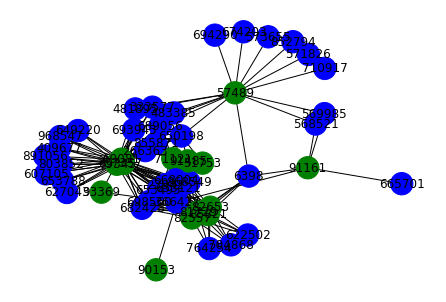

In [76]:
H = nx.subgraph(G, suspected_cluster)
nx.draw(H,with_labels = True,node_color=color_map(H),node_size=500)

# Conclusion:

By implementing a heuristical approach, we found an initial set of suspected uid and sid.

By using graph clustering, we extended the suspected uid/sid to a cluster of ids. Dependind on how much resource to investigate, we could start by investigating the result from the heuristical approach, then move to the graph approach.